In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Lasso
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score


Part 1. Data pre-processing and exploration
---
A) Load data and make training and test sets. 
--
Step 1: Need to manually add column names and read data. 

In [17]:
column_names = [
    'state','county','community','communityname','fold','population','householdsize','racepctblack',
    'racePctWhite','racePctAsian','racePctHisp','agePct12t21','agePct12t29','agePct16t24','agePct65up',
    'numbUrban','pctUrban','medIncome','pctWWage','pctWFarmSelf','pctWInvInc','pctWSocSec','pctWPubAsst',
    'pctWRetire','medFamInc','perCapInc','whitePerCap','blackPerCap','indianPerCap','AsianPerCap',
    'OtherPerCap','HispPerCap','NumUnderPov','PctPopUnderPov','PctLess9thGrade','PctNotHSGrad',
    'PctBSorMore','PctUnemployed','PctEmploy','PctEmplManu','PctEmplProfServ','PctOccupManu',
    'PctOccupMgmtProf','MalePctDivorce','MalePctNevMarr','FemalePctDiv','TotalPctDiv','PersPerFam',
    'PctFam2Par','PctKids2Par','PctYoungKids2Par','PctTeen2Par','PctWorkMomYoungKids',
    'PctWorkMom','NumIlleg','PctIlleg','NumImmig','PctImmigRecent','PctImmigRec5','PctImmigRec8',
    'PctImmigRec10','PctRecentImmig','PctRecImmig5','PctRecImmig8','PctRecImmig10','PctSpeakEnglOnly',
    'PctNotSpeakEnglWell','PctLargHouseFam','PctLargHouseOccup','PersPerOccupHous','PersPerOwnOccHous',
    'PersPerRentOccHous','PctPersOwnOccup','PctPersDenseHous','PctHousLess3BR','MedNumBR','HousVacant',
    'PctHousOccup','PctHousOwnOcc','PctVacantBoarded','PctVacMore6Mos','MedYrHousBuilt','PctHousNoPhone',
    'PctWOFullPlumb','OwnOccLowQuart','OwnOccMedVal','OwnOccHiQuart','RentLowQ','RentMedian','RentHighQ',
    'MedRent','MedRentPctHousInc','MedOwnCostPctInc','MedOwnCostPctIncNoMtg','NumInShelters',
    'NumStreet','PctForeignBorn','PctBornSameState','PctSameHouse85','PctSameCity85','PctSameState85',
    'LemasSwornFT','LemasSwFTPerPop','LemasSwFTFieldOps','LemasSwFTFieldPerPop','LemasTotalReq',
    'LemasTotReqPerPop','PolicReqPerOffic','PolicPerPop','RacialMatchCommPol','PctPolicWhite',
    'PctPolicBlack','PctPolicHisp','PctPolicAsian','PctPolicMinor','OfficAssgnDrugUnits',
    'NumKindsDrugsSeiz','PolicAveOTWorked','LandArea','PopDens','PctUsePubTrans','PolicCars',
    'PolicOperBudg','LemasPctPolicOnPatr','LemasGangUnitDeploy','LemasPctOfficDrugUn','PolicBudgPerPop',
    'ViolentCrimesPerPop'
]

In [18]:
data2 = pd.read_csv("../data/communities.csv", na_values='?', header = None, names = column_names)

In [19]:
pd.set_option("display.width", 300)
pd.set_option("display.max_columns", 9)
pd.set_option("display.float_format", "{:.2f}".format)  # Limit decimal places
print(data2.info())
print(data2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 128 entries, state to ViolentCrimesPerPop
dtypes: float64(125), int64(2), object(1)
memory usage: 1.9+ MB
None
      state  county  community        communityname  ...  LemasGangUnitDeploy  LemasPctOfficDrugUn  PolicBudgPerPop  ViolentCrimesPerPop
0         8     NaN        NaN         Lakewoodcity  ...                 0.50                 0.32             0.14                 0.20
1        53     NaN        NaN          Tukwilacity  ...                  NaN                 0.00              NaN                 0.67
2        24     NaN        NaN         Aberdeentown  ...                  NaN                 0.00              NaN                 0.43
3        34    5.00   81440.00  Willingborotownship  ...                  NaN                 0.00              NaN                 0.12
4        42   95.00    6096.00    Bethlehemtownship  ...                  NaN                 0.00              NaN      

STEP 2:
Based on the dataset description, we drop the non-predictive columns: state, county, community, communityname, fold
https://archive.ics.uci.edu/dataset/183/communities+and+crime

In [20]:
non_predictive = ['state', 'county', 'community', 'communityname', 'fold']
data2 = data2.drop(columns=non_predictive, errors='ignore')

STEP 3: Assign features and target. Split data to training and test. 

In [21]:
target_col = 'ViolentCrimesPerPop'
features = data2.drop(columns=[target_col])
target = data2[target_col]
X_train = features.iloc[:1495, :]
X_test = features.iloc[1495:, :]
y_train = target.iloc[:1495]
y_test = target.iloc[1495:]

B) IMPUTATION
--

We perform imputation after the train-test split. This ensures that no information from the test set leaks into the training process,
and the imputer is fit only on training data and then applied to the test set.
Steps: fit imputer on training data only, then transform both train and test. We use SimpleImputer from sklearn

Sources: 
https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

https://www.kaggle.com/code/alexisbcook/data-leakage

In [22]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [23]:
# Print shapes to confirm
print("Training features shape:", X_train_imputed.shape)
print("Testing features shape:", X_test_imputed.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

Training features shape: (1495, 122)
Testing features shape: (499, 122)
Training target shape: (1495,)
Testing target shape: (499,)


C) Correlation Matrix
--
Note: We use full data set (both test and train) to calculate correlation matrix. 
Source: https://seaborn.pydata.org/generated/seaborn.heatmap.html

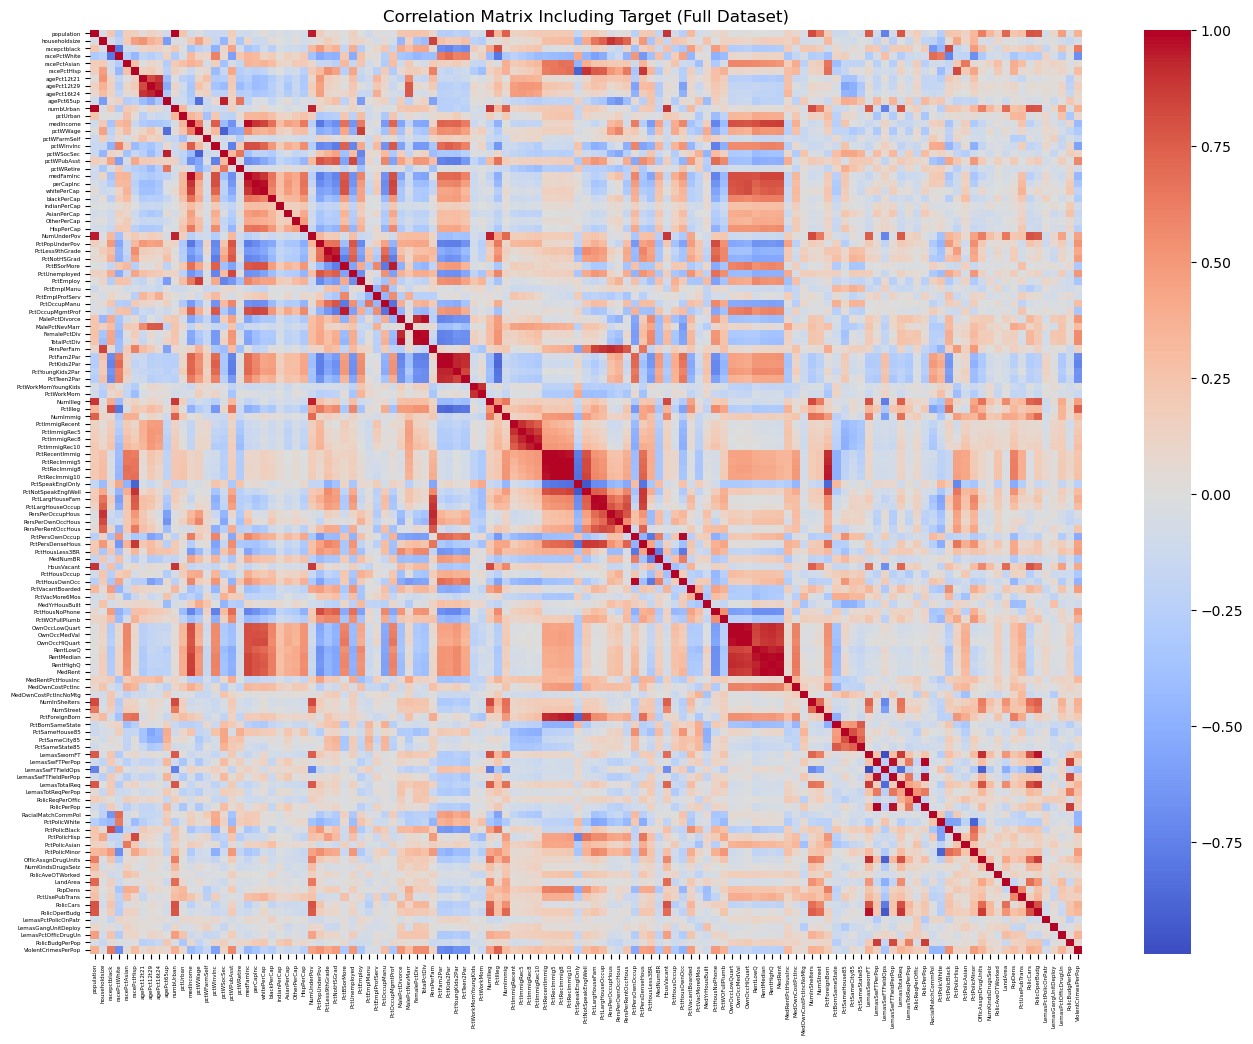

In [24]:
corr_matrix = data2.corr()
# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, xticklabels=1, yticklabels=1)
plt.xticks(rotation=90, fontsize=4)
plt.yticks(rotation=0, fontsize=4)
plt.title("Correlation Matrix Including Target (Full Dataset)")
plt.show()

D) Coefficient of Variation
--

In [25]:
cv_train = X_train_imputed.std() / X_train_imputed.mean()
cv_train_sorted = cv_train.sort_values(ascending=False)
print(cv_train_sorted)

NumStreet             4.29
NumInShelters         3.47
NumIlleg              3.06
NumImmig              2.93
LemasPctOfficDrugUn   2.55
                      ... 
NumKindsDrugsSeiz     0.14
RacialMatchCommPol    0.13
PctPolicWhite         0.12
LemasPctPolicOnPatr   0.12
LemasSwFTFieldOps     0.06
Length: 122, dtype: float64


E) Select top features with highest CV
-

In [26]:
top_k = int(np.floor(np.sqrt(128)))
top_features = cv_train_sorted.head(top_k).index.tolist()
print(top_features)

['NumStreet', 'NumInShelters', 'NumIlleg', 'NumImmig', 'LemasPctOfficDrugUn', 'NumUnderPov', 'population', 'numbUrban', 'HousVacant', 'LandArea', 'racePctHisp']


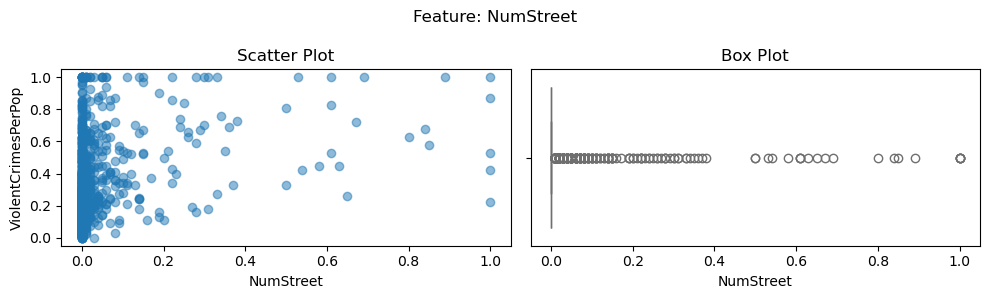

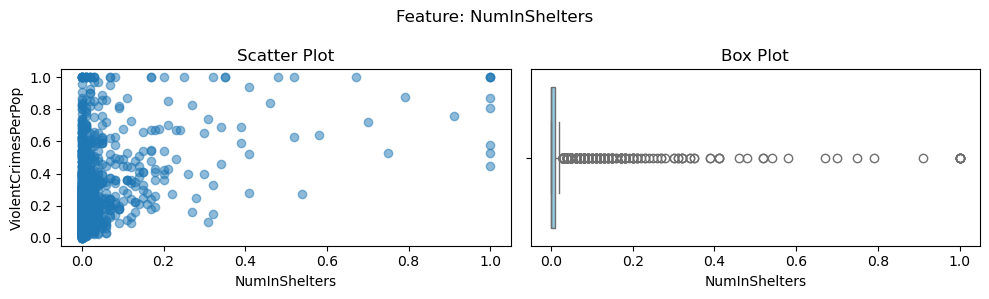

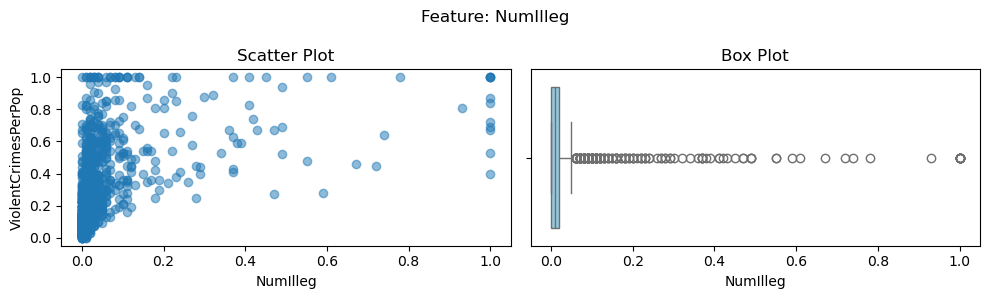

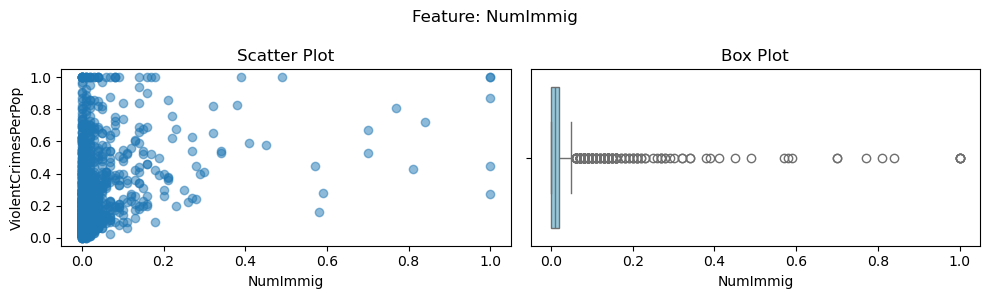

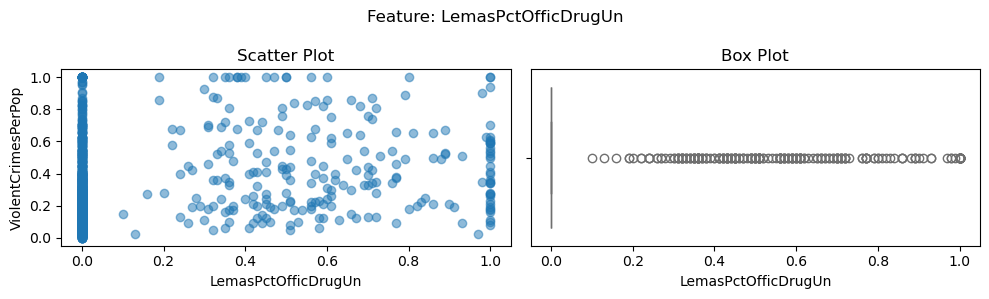

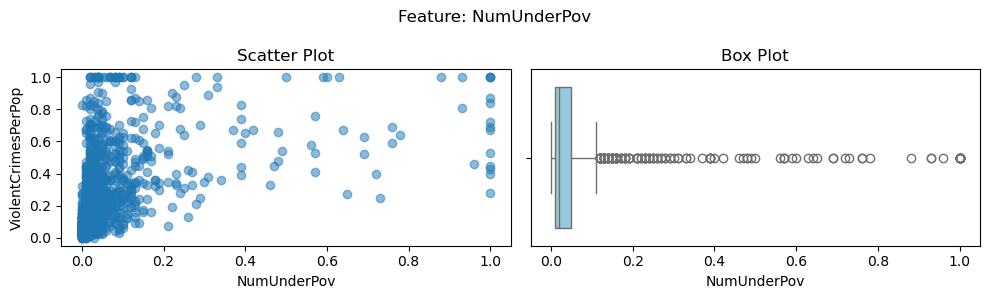

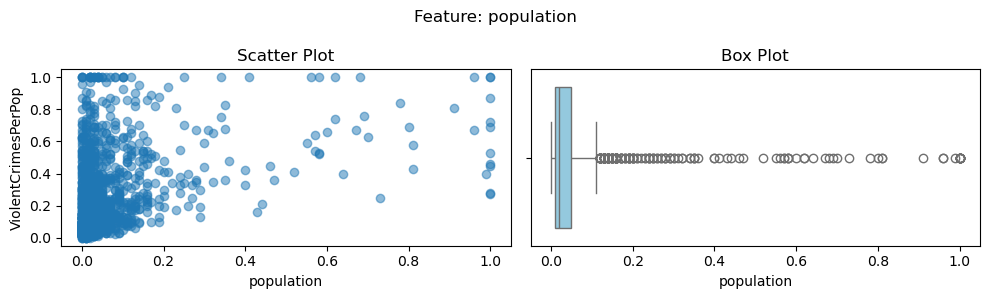

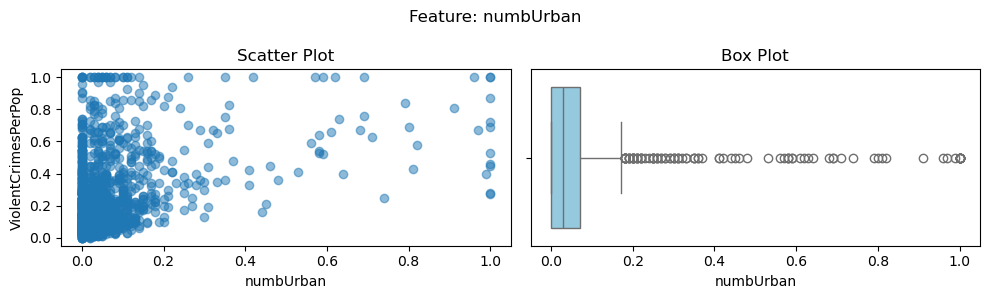

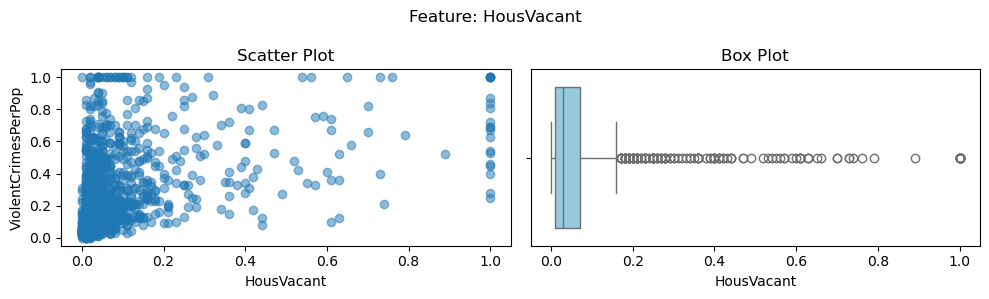

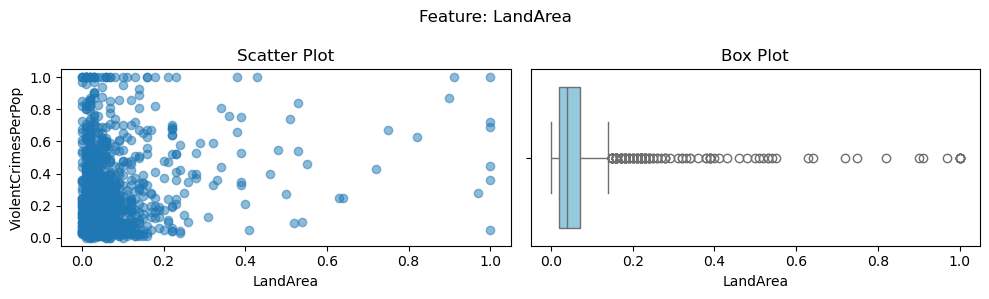

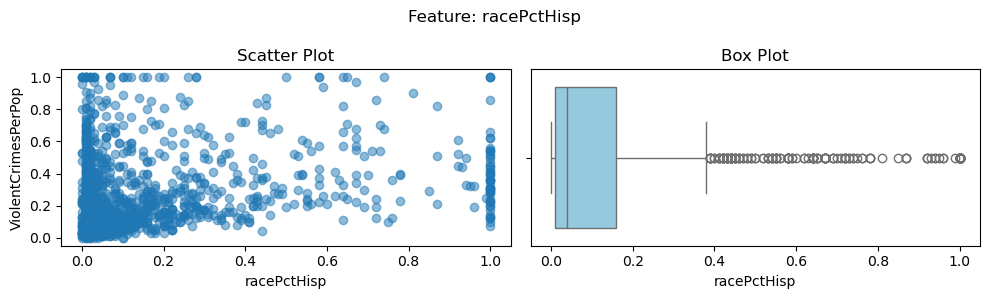

In [27]:
for feature in top_features:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    fig.suptitle(f"Feature: {feature}")

    # Scatter plot vs target
    axes[0].scatter(X_train_imputed[feature], y_train, alpha=0.5)
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel("ViolentCrimesPerPop")
    axes[0].set_title("Scatter Plot")

    # Box plot of the feature
    sns.boxplot(x=X_train_imputed[feature], ax=axes[1], color='skyblue')
    axes[1].set_title("Box Plot")

    plt.tight_layout()
    plt.show()


We cannot draw definite conclusions regatding significance of features from the above graphs but we can make some observations. 
We will need to fit models to examine the feature coefficients and p-values. 

Observations:
-
1) NumStreet / NumInShelters / NumImmig / NumIlleg:
   Most values cluster near 0 with occasional large spikes. These features were selected in CV due to high variance but outliers dominate    variance. May not be truly informative.
2) LemasPctOfficDrugUn: Data points cluster around 0 and 1. Might capture communities with different policing strategies which could influence crime
3) HousVacant / LandArea: Wide scatter, many zeroes, no clear trend. Potentially noisy without transformation.
   

Part 2. Model Fit.
--
A) Simple Linear Model. Test MSE = 0.0181
-

In [28]:
# Add constant term for intercept
X_train_sm = sm.add_constant(X_train_imputed)
X_test_sm = sm.add_constant(X_test_imputed)

# Fit model
sm_model = sm.OLS(y_train, X_train_sm).fit()

# Predict on test set
y_pred = sm_model.predict(X_test_sm)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Q2(f): Linear Regression Evaluation (Statsmodels)")
print("MSE on Test Set:", round(mse, 6))
print("R^2 on Test Set:", round(r2, 6))

# Show full regression summary
print(sm_model.summary())


Q2(f): Linear Regression Evaluation (Statsmodels)
MSE on Test Set: 0.018142
R^2 on Test Set: 0.618508
                             OLS Regression Results                            
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.711
Model:                             OLS   Adj. R-squared:                  0.686
Method:                  Least Squares   F-statistic:                     27.94
Date:                 Sat, 29 Mar 2025   Prob (F-statistic):          6.56e-291
Time:                         22:40:53   Log-Likelihood:                 955.40
No. Observations:                 1495   AIC:                            -1667.
Df Residuals:                     1373   BIC:                            -1019.
Df Model:                          121                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------

B) Ridge Regression. Test MSE: 0.0175
-
Step 1: Standardize: recommended to standardize features for ridge regression. 

Step 2: Perform cross validation to find best lambda. 

Step 3: Train model using selected lambda on full training data set.  

Step 4: Evaluate on test set. 

Source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html


In [29]:
#Step 1: Standardize features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
# Step 2: Perform cross-validation to find best alpha (lambda)
alphas = np.logspace(-3, 3, 100)
ridge_cv = RidgeCV(alphas=alphas)

#Step 3. Train model using selected lambda on full training data. 
ridge_cv.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e-03, 1.07226722e-02, 1.23284674e-02, 1.41747416e-02,
       1.62975083e-02, 1.87381742e-0...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]))

In [30]:
#Step 4: Evaluate on test set
y_pred_ridge = ridge_cv.predict(X_test_scaled)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)
print("Best Lambda (alpha):", ridge_cv.alpha_)
print("MSE on Test Set:", round(ridge_mse, 6))
print("R^2 on Test Set:", round(ridge_r2, 6))

Best Lambda (alpha): 81.11308307896873
MSE on Test Set: 0.017538
R^2 on Test Set: 0.631215


C) LASSO. MSE: 0.0178
-
Source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

Follow similar steps as in Ridge for LASSO
We do LASSO regression on both non-standardized and standardized features. 
We find best lambda using cross validation


In [31]:
# Lasso on non-standardized features
lasso_nonstd = LassoCV(cv=5, alphas=None, max_iter=10000)
lasso_nonstd.fit(X_train_imputed, y_train)
y_pred_lasso_nonstd = lasso_nonstd.predict(X_test_imputed)

# Lasso on standardized features
lasso_std = LassoCV(cv=5, alphas=None, max_iter=10000)
lasso_std.fit(X_train_scaled, y_train)
y_pred_lasso_std = lasso_std.predict(X_test_scaled)

# Evaluate both on test 
mse_nonstd = mean_squared_error(y_test, y_pred_lasso_nonstd)
r2_nonstd = r2_score(y_test, y_pred_lasso_nonstd)

mse_std = mean_squared_error(y_test, y_pred_lasso_std)
r2_std = r2_score(y_test, y_pred_lasso_std)

print("\nLasso Regression Evaluation")
print("Non-Standardized")
print("MSE:", round(mse_nonstd, 4), " R^2:", round(r2_nonstd, 6))
print("Standardized")
print("MSE:", round(mse_std, 4), " R^2:", round(r2_std, 6))

# Extract and display selected features
coeffs_lasso_nonstd = pd.Series(lasso_nonstd.coef_, index=X_train_imputed.columns)
coeffs_lasso_std = pd.Series(lasso_std.coef_, index=X_train_imputed.columns)

selected_nonstd = coeffs_lasso_nonstd[coeffs_lasso_nonstd != 0].index.tolist()
selected_std = coeffs_lasso_std[coeffs_lasso_std != 0].index.tolist()

print("\nSelected Features (Non-Standardized):")
print(f"Count: {len(selected_nonstd)}")
print(selected_nonstd)
print("\nSelected Features (Standardized):")
print(f"Count: {len(selected_std)}")
print(selected_std)



Lasso Regression Evaluation
Non-Standardized
MSE: 0.0178  R^2: 0.626578
Standardized
MSE: 0.0178  R^2: 0.625587

Selected Features (Non-Standardized):
Count: 75
['racepctblack', 'racePctAsian', 'agePct12t21', 'agePct12t29', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctEmploy', 'PctEmplManu', 'PctOccupManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec10', 'PctRecImmig10', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'RentLowQ', 'MedRent', 'MedRentPctHousInc', 'Med

Test error for both standardized and non-standardized is the same. 

In Standardized version, number of features selected is 73 but for non-standardized it is 75.

D) PCR. MSE: 0.0182
-
Source: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

STEP 1: We standardize features as recommended in ISLR page 260. 

STEP 2: Fit PCA on training set. PCA identifies directions (principal components) along which X has the most variance.

These directions are computed purely from X, without knowing anything about y.

STEP 3: Select number of components M via cross-validation. For Each M from 1 to total features, evaluate MSE using 5-fold CV on Linear Regression

Step 4: Fit final model on selected M components and evaluate on test set

In [32]:
# 1. Standardize X (without mean-centering)
X_train_std = X_train_imputed / X_train_imputed.std()
X_test_std = X_test_imputed / X_train_imputed.std()

# 2. Apply PCA (unsupervised, using only X)
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# 3. Use CV to select number of components M (do not let y influence PCA)
mse_scores = []
for m in range(1, X_train_pca.shape[1] + 1):
    X_train_reduced = X_train_pca[:, :m]
    score = cross_val_score(LinearRegression(), X_train_reduced, y_train,
                            scoring='neg_mean_squared_error', cv=5).mean()
    mse_scores.append(-score)

best_m = np.argmin(mse_scores) + 1
print(f"Q2(i): PCR - Best number of components (M): {best_m}")

# 4. Fit final model using best M PCs
X_train_final = X_train_pca[:, :best_m]
X_test_final = X_test_pca[:, :best_m]

pcr_final_model = LinearRegression()
pcr_final_model.fit(X_train_final, y_train)
y_pred_final = pcr_final_model.predict(X_test_final)

mse_pcr = mean_squared_error(y_test, y_pred_final)
r2_pcr = r2_score(y_test, y_pred_final)

print("PCR Test MSE:", round(mse_pcr, 6))
print("PCR Test R^2:", round(r2_pcr, 6))

Q2(i): PCR - Best number of components (M): 95
PCR Test MSE: 0.018393
PCR Test R^2: 0.613231


E) XGBoost. MSE: 0.018
-

In [33]:
# Install XGBoost (if not already installed)
!pip install xgboost

In [34]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [35]:
# Initialize XGBoost regressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=0)

# Define hyperparameter grid for L1 regularization (reg_alpha)
param_grid = {
    'reg_alpha': [0.0, 0.1, 1.0, 10.0]  # L1 penalty values
}

# Perform 5-fold cross-validation to select best reg_alpha
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           n_jobs=-1)

# Fit on imputed training data
grid_search.fit(X_train_imputed, y_train)
# Retrieve best reg_alpha
best_alpha = grid_search.best_params_['reg_alpha']
print(f"Best reg_alpha from 5-fold CV: {best_alpha:.2f}")


Best reg_alpha from 5-fold CV: 1.00


In [36]:
# Train final model with best reg_alpha
final_model = XGBRegressor(objective='reg:squarederror', random_state=0, reg_alpha=best_alpha)
final_model.fit(X_train_imputed, y_train)

# Predict and evaluate on test set
y_pred = final_model.predict(X_test_imputed)
mse_xgb = mean_squared_error(y_test, y_pred)
r2_xgb = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.5f}")
print(f"Test R^2: {r2_xgb:.5f}")

Test MSE: 0.01814
Test R^2: 0.62680


SUMMARY OF ALL MSE FROM ABOVE MODELS: 
-

In [38]:
# Summary of MSE for all models (rounded to 6 decimal places)
mse_summary = {
    'XGBoost': round(mse, 6),
    'Ridge': round(ridge_mse, 6),
    'Lasso (Standardized)': round(mse_std, 6),
    'PCR': round(mse_pcr, 6),
    'Linear Regression': round(mse_nonstd, 6)
}

print("Summary of MSEs:")
for model, value in mse_summary.items():
    print(f"{model}: {value}")

Summary of MSEs:
XGBoost: 0.018142
Ridge: 0.017538
Lasso (Standardized): 0.017805
PCR: 0.018393
Linear Regression: 0.017758


Sources / References:

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

https://www.kaggle.com/code/alexisbcook/data-leakage

https://seaborn.pydata.org/generated/seaborn.heatmap.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

https://xgboost.readthedocs.io/en/release_3.0.0/

https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn
